In [1]:
import wandb
import pandas as pd
import pickle
import seaborn as sns 
import functools
import operator 

In [2]:
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

id_df = read_wandb_csv("data/A_5_diff_eval.csv")
id_df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,ID,Group,...,test_f1_best_eval_loss,test_f1_best_f1,train_loss,train_p_max,train_p_var,train_st1_loss,train_st1_p_max,train_st2_loss,train_st2_p_max,vector_norms
0,27_S3_ID_09_VAN,finished,-,ricu,"SWP3, vanilla",2024-01-14T19:18:57.000Z,166,NaN,bwu5jrev,NaN,...,0.681267,0.718785,NaN,NaN,NaN,NaN,NaN,0.080889,0.965768,NaN
1,27_S3_ID_08_VAN,finished,-,ricu,"SWP3, vanilla",2024-01-14T19:15:27.000Z,159,NaN,e58vviw3,NaN,...,0.663275,0.693231,NaN,NaN,NaN,NaN,NaN,0.005789,0.997502,NaN
2,27_S3_ID_07_VAN,finished,-,ricu,"SWP3, vanilla",2024-01-14T19:11:52.000Z,160,NaN,sh1nnolb,NaN,...,0.659745,0.693378,NaN,NaN,NaN,NaN,NaN,0.001247,0.998757,NaN
3,27_S3_ID_06_VAN,finished,-,ricu,"SWP3, vanilla",2024-01-14T19:08:22.000Z,160,NaN,4fxge1ue,NaN,...,0.690989,0.697987,NaN,NaN,NaN,NaN,NaN,0.009028,0.997511,NaN
4,27_S3_ID_05_VAN,finished,-,ricu,"SWP3, vanilla",2024-01-14T19:04:41.000Z,166,NaN,qzjamdb0,NaN,...,0.707104,0.719780,NaN,NaN,NaN,NaN,NaN,0.004029,0.998340,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,27_S0_ID_04_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T11:48:56.000Z,277,NaN,6k78yk2i,NaN,...,0.658084,0.662768,NaN,NaN,NaN,0.000245,0.999755,0.001164,0.998907,"{""_type"":""histogram"",""bins"":[0.000002004347606..."
114,27_S0_ID_03_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T11:43:20.000Z,284,NaN,hzonoas3,NaN,...,0.542151,0.660503,NaN,NaN,NaN,0.000316,0.999684,0.040227,0.998755,"{""_type"":""histogram"",""bins"":[7.583346359751886..."
115,27_S0_ID_02_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T11:37:44.000Z,286,NaN,4fu9i5y1,NaN,...,0.644809,0.683049,NaN,NaN,NaN,0.000190,0.999810,0.005568,0.998342,"{""_type"":""histogram"",""bins"":[8.254384056272102..."
116,27_S0_ID_01_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T11:32:05.000Z,288,NaN,zcznijxn,NaN,...,0.665080,0.674107,NaN,NaN,NaN,0.000264,0.999735,0.000557,0.999443,"{""bins"":[6.946341954972013e-7,0.00069777027238..."


In [6]:
from tqdm import tqdm
run_ids = id_df["ID"]

api = wandb.Api()

all_dfs = []
metrics_train = ["train_st2_loss"]
metrics_eval = ["accuracy","f1","eval_loss","eval_p_max"]
metrics_lr = ["learning_rate"]
index_keys = ["_step","epoch"]

# Add tqdm to the loop for progress bar
for run_id in tqdm(run_ids):
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the history
    history_train = run.scan_history(keys=metrics_train+index_keys)
    df_run =  pd.DataFrame([row for row in history_train])
    
    history_eval = run.scan_history(keys=metrics_eval+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_eval]), on=['_step', 'epoch'], how='outer')
    
    history_lr = run.scan_history(keys=metrics_lr+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_lr]), on=['_step', 'epoch'], how='outer')
    df_run = df_run.sort_values(by="_step", ascending=True,ignore_index=True)
    # last_step_diff = df_run["_step"].iloc[-1] - df_run["_step"].iloc[-2]
    # first_step_diff = df_run["_step"].iloc[1] - df_run["_step"].iloc[0]
    # if last_step_diff != first_step_diff:
    #     df_run.at[df_run.index[-1], 'train_st2_loss'] = df_run['train_st2_loss'].iloc[-1] / last_step_diff
    df_run["learning_rate"] = df_run["learning_rate"].fillna(0)

    for key, value in run.config.items():
        df_run = df_run.assign(**{key: value})
    
    all_dfs.append(df_run)

df = pd.concat(all_dfs,axis=0,ignore_index=True)
df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})
with open("data/A_4_dataset.pkl",'wb') as f:
    pickle.dump(df,f)

  0%|          | 0/118 [00:00<?, ?it/s]

  8%|▊         | 10/118 [00:29<05:19,  2.95s/it]


KeyError: '_step'

In [4]:
with open("data/A_4_dataset.pkl",'rb') as f:
    df = pickle.load(f)
df.head()

,train_st2_loss,_step,epoch,accuracy,eval_loss,eval_p_max,learning_rate,seed,beta1,beta2,...,lr_scheduler_type,pad_to_max_length,model_name_or_path,warmup_steps_fraction,early_stopping_patience,ignore_mismatched_sizes,early_stopping_min_delta,per_device_eval_batch_size,per_device_train_batch_size,mode
0,NaN,0,-1,0.602051,0.704979,0.713483,0.00001,1,0.9,0.999,...,linear,False,bert-base-uncased,0.1,13,False,0,128,32,VANILLA
1,0.686545,64,1,0.626953,0.635306,0.604031,0.00001,1,0.9,0.999,...,linear,False,bert-base-uncased,0.1,13,False,0,128,32,VANILLA
2,0.594092,128,3,0.639648,0.607967,0.712124,0.00001,1,0.9,0.999,...,linear,False,bert-base-uncased,0.1,13,False,0,128,32,VANILLA
3,0.464027,192,5,0.666016,0.682482,0.837237,0.00001,1,0.9,0.999,...,linear,False,bert-base-uncased,0.1,13,False,0,128,32,VANILLA
4,0.358921,256,7,0.735840,0.640302,0.874014,0.00001,1,0.9,0.999,...,linear,False,bert-base-uncased,0.1,13,False,0,128,32,VANILLA


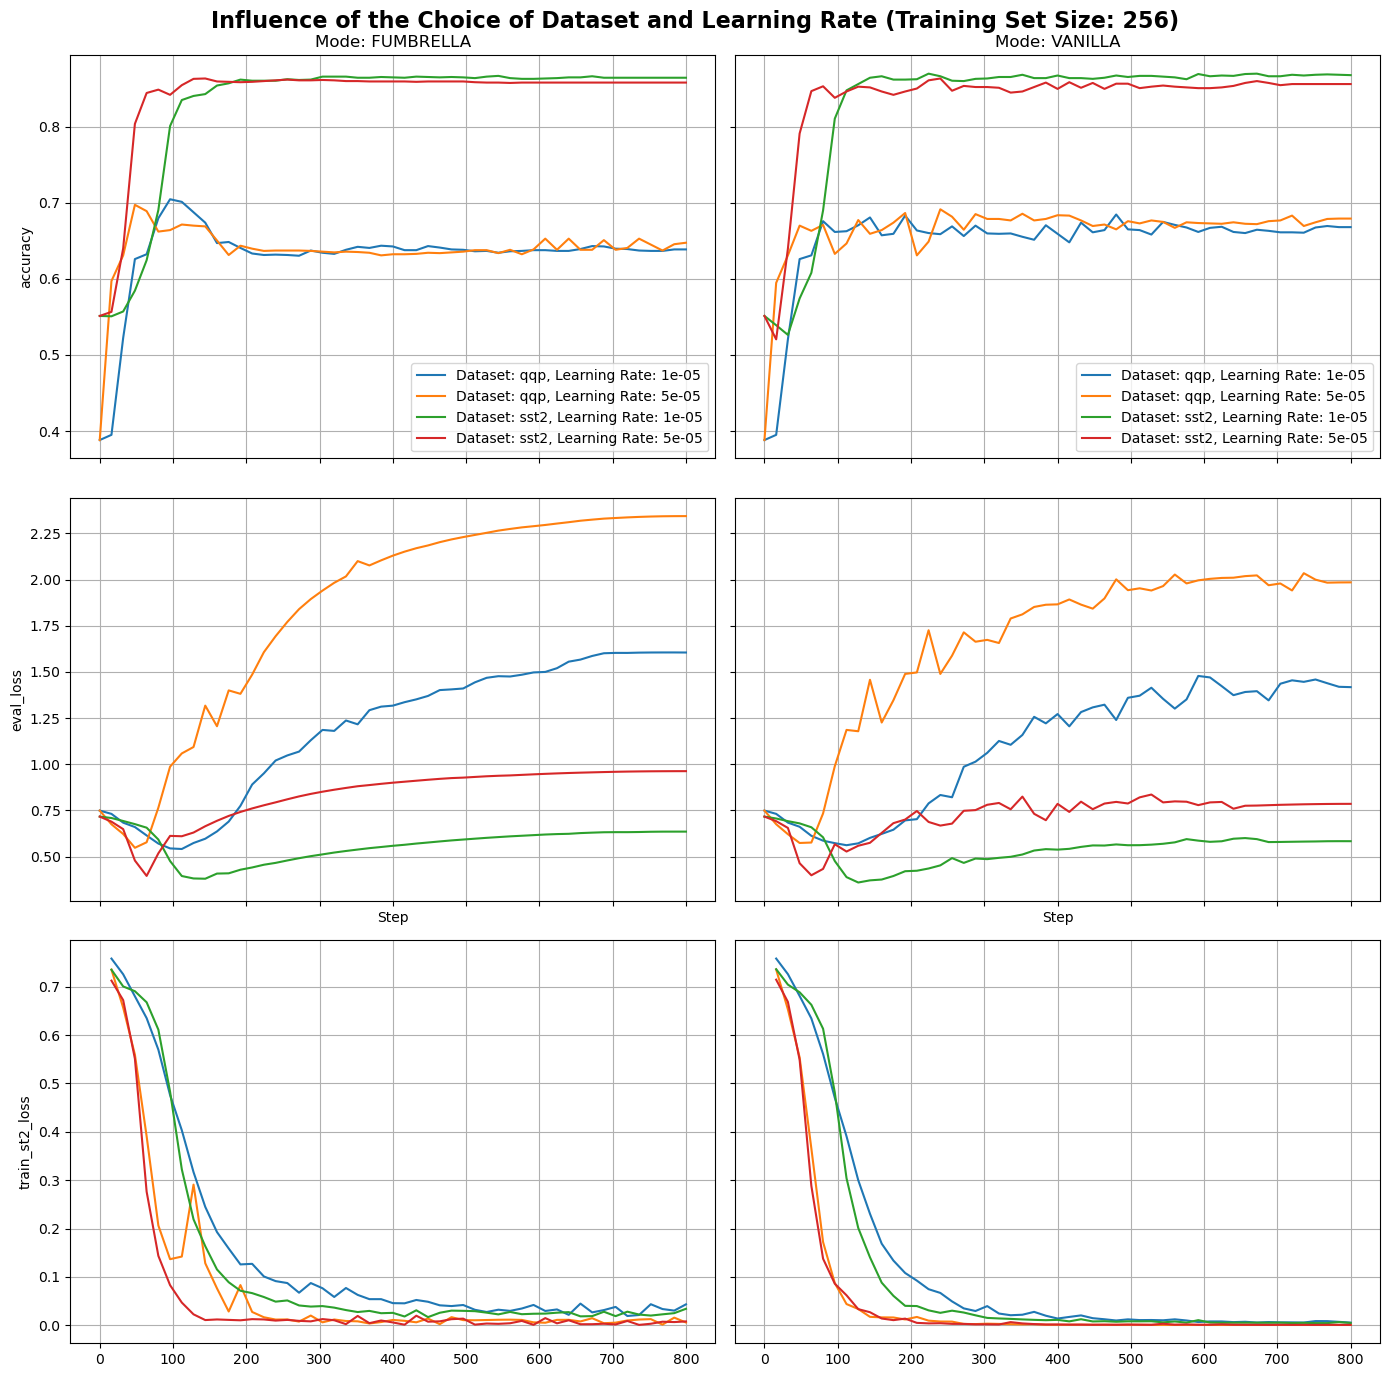

In [5]:
import matplotlib.pyplot as plt
selected_rows = functools.reduce(
    operator.and_,
    [
        df["training_size"] == 256
        # df["Tags"].str.contains('modded')
    ]  
    )
filtered_df = df.loc[selected_rows]

subplot_columns = sorted(df["mode"].unique())
subplot_rows = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    len(subplot_rows),
    len(subplot_columns),
    sharex=True,
    sharey='row',
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idy, col_val in enumerate(subplot_columns):
    for idx, row_val in enumerate(subplot_rows):
        grouped_df = filtered_df.loc[df["mode"]==col_val].groupby(["task_name","learning_rate","_step"])
        statistics = grouped_df[row_val].agg(['mean', 'median', 'std'])
        statistics = statistics.sort_index(level=["task_name","learning_rate"], ascending=False)

        for (task_name, learning_rate), group in statistics.groupby(level=['task_name', 'learning_rate']):
            axs[idx,idy].plot(
                group.index.get_level_values('_step'),
                group["median"],
                label=f'Dataset: {task_name}, Learning Rate: {learning_rate}'
                )

        if idy == 0:
            axs[idx,idy].set_ylabel(row_val)
        if idx == 0:
            axs[idx,idy].set_title(f'Mode: {col_val}')
        if idx == len(subplot_columns) - 1:
            axs[idx,idy].set_xlabel('Step')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idx == 0:
            axs[idx,idy].legend()


fig.suptitle('Influence of the Choice of Dataset and Learning Rate (Training Set Size: 256)', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_4_dataset.pdf', format='pdf')
plt.show()